## llm

In [1]:
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def inference(save_path):
    binary_labels = []
    predictions = []
    with open(save_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            label = 1 if data['label'] == 'hate' else 0
            predict = 1 if data['predict'] == 'hate' else 0
            binary_labels.append(label)
            predictions.append(predict)

    accuracy = accuracy_score(binary_labels, predictions)
    precision = precision_score(binary_labels, predictions)
    recall = recall_score(binary_labels, predictions)
    f1 = f1_score(binary_labels, predictions)

    # 打印结果
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

In [4]:
inference('/hpc2hdd/home/dxing004/jhaidata/temp/LLaMA-Factory/saves/ChatGLM3-6B-Chat/lora/eval_ToxiCNImplicit/generated_predictions.jsonl')

Accuracy: 0.7533834586466165
Precision: 1.0
Recall: 0.7533834586466165
F1-score: 0.8593481989708405


In [5]:
inference('/hpc2hdd/home/dxing004/jhaidata/temp/LLaMA-Factory/saves/ChatGLM3-6B-Chat/lora/eval_ToxiCNReported/generated_predictions.jsonl')

Accuracy: 0.7962760131434831
Precision: 1.0
Recall: 0.7962760131434831
F1-score: 0.8865853658536585


In [6]:
inference('/hpc2hdd/home/dxing004/jhaidata/temp/LLaMA-Factory/saves/ChatGLM3-6B-Chat/lora/eval_ToxiCNExplicit/generated_predictions.jsonl')

Accuracy: 0.8987943003288272
Precision: 1.0
Recall: 0.8987943003288272
F1-score: 0.9467000192418703


## bert

In [1]:
import pandas as pd

df = pd.read_csv('/hpc2hdd/home/dxing004/project/inputdata/ToxiCN_1.0.csv')

In [ ]:
df.head(2)

In [2]:
test_ratio=0.2
test_count = int(len(df) * test_ratio)
test_data = df[:test_count]
train_data = df[test_count:]

In [10]:
test_data_implicit = test_data[test_data['expression'] == 2].copy()
len(test_data_implicit)

434

In [5]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments

from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path="/hpc2hdd/home/dxing004/model/roberta/roberta-base-finetuned-dianping-chinese"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.texts = data['content'].tolist()
        self.labels = data['toxic'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=512)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(label)
        }

In [ ]:
# 创建训练集和测试集的数据集对象
train_dataset = CustomDataset(train_data, tokenizer)
test_dataset = CustomDataset(test_data_implicit, tokenizer)

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [7]:
training_args = TrainingArguments(
    output_dir="/hpc2hdd/home/dxing004/project/roberta_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    #logging_dir="./logs",
    #logging_steps=10,
    evaluation_strategy="epoch",  # 在每个epoch结束时评估
)

In [20]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.344800,0.757167,0.751152,0.857895,1.000000,0.751152
2,0.398500,0.745051,0.762673,0.865359,1.000000,0.762673
3,0.307600,1.111730,0.698157,0.822252,1.000000,0.698157


TrainOutput(global_step=3606, training_loss=0.3651878602360595, metrics={'train_runtime': 775.3458, 'train_samples_per_second': 37.18, 'train_steps_per_second': 4.651, 'total_flos': 7584702392862720.0, 'train_loss': 0.3651878602360595, 'epoch': 3.0})

In [32]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564600,0.551960,0.670507,0.802759,1.000000,0.670507
2,0.479800,0.482528,0.746544,0.854881,1.000000,0.746544
3,0.385900,0.841310,0.698157,0.822252,1.000000,0.698157


Checkpoint destination directory /hpc2hdd/home/dxing004/project/roberta_finetuned/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /hpc2hdd/home/dxing004/project/roberta_finetuned/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=3606, training_loss=0.49327503781945453, metrics={'train_runtime': 685.9962, 'train_samples_per_second': 42.022, 'train_steps_per_second': 5.257, 'total_flos': 7584702392862720.0, 'train_loss': 0.49327503781945453, 'epoch': 3.0})

In [6]:
from peft import LoraConfig, get_peft_model
# 使用LORA进行微调
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)
peft_model = get_peft_model(model, peft_config)

In [13]:
# 初始化Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 开始训练和评估
trainer.train()

/hpc2hdd/home/dxing004/.local/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.562800,0.615416,0.679724,0.809328,1.000000,0.679724
2,0.547400,0.649054,0.652074,0.789400,1.000000,0.652074
3,0.522700,0.653901,0.638249,0.779184,1.000000,0.638249


Checkpoint destination directory /hpc2hdd/home/dxing004/project/roberta_finetuned/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/hpc2hdd/home/dxing004/.local/lib/python3.10/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /hpc2hdd/home/dxing004/model/roberta/roberta-base-finetuned-dianping-chinese - will assume that the vocabulary was not modified.
  warnings.warn(
Checkpoint destination directory /hpc2hdd/home/dxing004/project/roberta_finetuned/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/hpc2hdd/home/dxing004/.local/lib/python3.10/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /hpc2hdd/home/dxing004/model/roberta/roberta-base-finetuned-dianping-chinese - will assume that the vocabulary was not modified.
  warnings.warn(
Checkpoint destination directory /hpc2hdd/home/dxing004/project/r

TrainOutput(global_step=3606, training_loss=0.5454313243288367, metrics={'train_runtime': 531.5796, 'train_samples_per_second': 54.229, 'train_steps_per_second': 6.784, 'total_flos': 7610954980331520.0, 'train_loss': 0.5454313243288367, 'epoch': 3.0})

In [21]:
COLD= pd.read_csv('/hpc2hdd/home/dxing004/project/inputdata/COLD_test.csv')
CHSD= pd.read_csv('/hpc2hdd/home/dxing004/project/inputdata/CHSD_test.csv')

class CustomDataset1(Dataset):
    def __init__(self, data, tokenizer):
        self.texts = data['TEXT'].tolist()
        self.labels = data['label'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=512)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(label)
        }
testCOLD_dataset = CustomDataset1(COLD, tokenizer)

class CustomDataset2(Dataset):
    def __init__(self, data, tokenizer):
        self.texts = data['text'].tolist()
        self.labels = data['label'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=512)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(label)
        }
testCHSD_dataset = CustomDataset2(CHSD, tokenizer)

In [22]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=testCOLD_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.226200,0.939190,0.704490,0.638308,0.619090,0.658757
2,0.216800,1.156578,0.720458,0.669774,0.629012,0.716184
3,0.182400,1.306174,0.711253,0.678385,0.606662,0.769340


TrainOutput(global_step=3606, training_loss=0.22280109001409326, metrics={'train_runtime': 907.9017, 'train_samples_per_second': 31.751, 'train_steps_per_second': 3.972, 'total_flos': 7584702392862720.0, 'train_loss': 0.22280109001409326, 'epoch': 3.0})

In [23]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=testCHSD_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.170800,1.410704,0.633264,0.689579,0.579844,0.850543
2,0.170900,1.479296,0.692608,0.672399,0.686686,0.658696
3,0.159800,1.450090,0.693909,0.696124,0.663547,0.732065


TrainOutput(global_step=3606, training_loss=0.16510525532583362, metrics={'train_runtime': 867.3524, 'train_samples_per_second': 33.236, 'train_steps_per_second': 4.157, 'total_flos': 7584702392862720.0, 'train_loss': 0.16510525532583362, 'epoch': 3.0})

In [11]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments

from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path="/hpc2hdd/home/dxing004/model/roberta/roberta-base-finetuned-dianping-chinese"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.texts = data['content'].tolist()
        self.labels = data['toxic'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=512)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(label)
        }

# 创建训练集和测试集的数据集对象
train_dataset = CustomDataset(train_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)

In [15]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.374300,0.637194,0.753539,0.750632,0.828067,0.686441
2,0.347400,0.791343,0.769359,0.777331,0.812605,0.744992
3,0.280100,0.748206,0.790591,0.804660,0.811276,0.798151


TrainOutput(global_step=3606, training_loss=0.334255494082298, metrics={'train_runtime': 730.0805, 'train_samples_per_second': 39.485, 'train_steps_per_second': 4.939, 'total_flos': 7584702392862720.0, 'train_loss': 0.334255494082298, 'epoch': 3.0})

In [16]:
test_data_xianxing = test_data[test_data['expression'] == 1].copy()
len(test_data_xianxing)
test_dataset = CustomDataset(test_data_xianxing, tokenizer)

In [17]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.293600,0.315236,0.923372,0.960159,1.000000,0.923372
2,0.327000,0.290858,0.936782,0.967359,1.000000,0.936782
3,0.283700,0.250000,0.923372,0.960159,1.000000,0.923372


TrainOutput(global_step=3606, training_loss=0.28731920239135944, metrics={'train_runtime': 687.014, 'train_samples_per_second': 41.96, 'train_steps_per_second': 5.249, 'total_flos': 7584702392862720.0, 'train_loss': 0.28731920239135944, 'epoch': 3.0})

In [10]:
test_data_zhuanshu = test_data[test_data['expression'] == 3].copy()
len(test_data_zhuanshu)
test_dataset = CustomDataset(test_data_zhuanshu, tokenizer)
train_dataset = CustomDataset(train_data, tokenizer)

In [11]:
# 创建 Trainer 对象并开始训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jsrdxdy. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564600,0.397611,0.790055,0.882716,1.000000,0.790055
2,0.479800,0.294093,0.856354,0.922619,1.000000,0.856354
3,0.385900,0.401324,0.861878,0.925816,1.000000,0.861878


TrainOutput(global_step=3606, training_loss=0.49327503781945453, metrics={'train_runtime': 691.2096, 'train_samples_per_second': 41.705, 'train_steps_per_second': 5.217, 'total_flos': 7584702392862720.0, 'train_loss': 0.49327503781945453, 'epoch': 3.0})

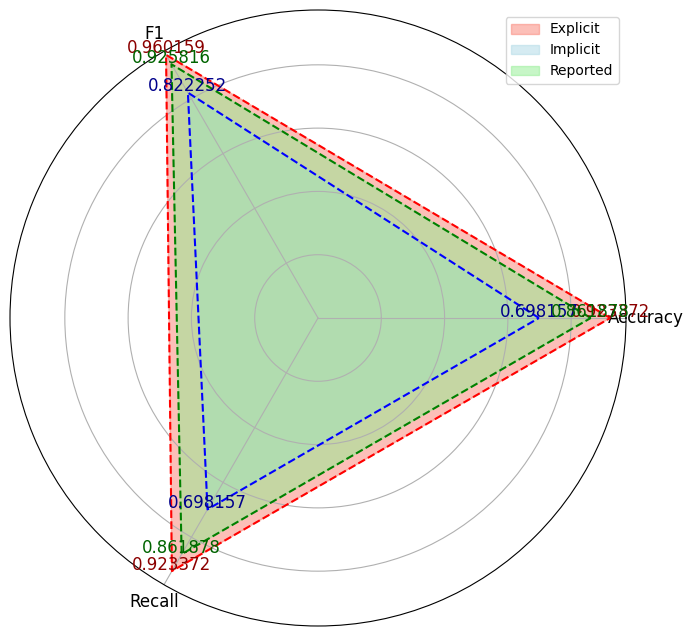

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
 
labels=np.array(["Accuracy","F1","Recall"])
 
xianxing= np.array([0.923372, 0.960159, 0.923372])
implicit = np.array([0.698157, 0.822252,0.698157])
zhuanshu=np.array([0.861878, 0.925816, 0.861878])
 
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
 
xianxing=np.concatenate((xianxing,[xianxing[0]]))
implicit=np.concatenate((implicit,[implicit[0]]))
zhuanshu=np.concatenate((zhuanshu,[zhuanshu[0]]))
angles+=angles[:1]
 
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
 
ax.fill(angles, xianxing, color='salmon', alpha=0.5)
ax.fill(angles, implicit, color='lightblue', alpha=0.5)
ax.fill(angles, zhuanshu, color='lightgreen', alpha=0.5)

ax.plot(angles, xianxing, color='red', linewidth=1.5, linestyle='dashed')
ax.plot(angles, implicit, color='blue', linewidth=1.5, linestyle='dashed')
ax.plot(angles, zhuanshu, color='green', linewidth=1.5, linestyle='dashed')
 
for i in range(len(labels)):
    ax.annotate(xianxing[i], (angles[i], xianxing[i]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=12, color='darkred')
    ax.annotate(implicit[i], (angles[i], implicit[i]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=12, color='darkblue')
    ax.annotate(zhuanshu[i], (angles[i], zhuanshu[i]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=12, color='darkgreen')
 
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
 
plt.legend(['Explicit', 'Implicit','Reported'], loc='upper right')
 
plt.show()

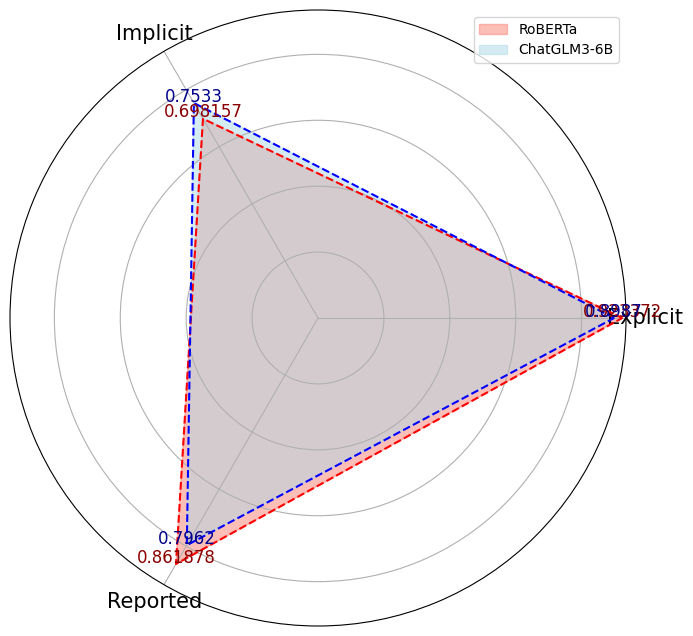

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
 
labels=np.array(['Explicit', 'Implicit','Reported'])
 
roberta= np.array([0.923372, 0.698157, 0.861878])
llm = np.array([0.8987, 0.7533,0.7962])
 
# 计算角度
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
 
# 使雷达图封闭
roberta=np.concatenate((roberta,[roberta[0]]))
llm=np.concatenate((llm,[llm[0]]))
angles+=angles[:1]
 
# 画图
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
 
# 雷达填充
ax.fill(angles, roberta, color='salmon', alpha=0.5)
ax.fill(angles, llm, color='lightblue', alpha=0.5)

# 添加连线
ax.plot(angles, roberta, color='red', linewidth=1.5, linestyle='dashed')
ax.plot(angles, llm, color='blue', linewidth=1.5, linestyle='dashed')
 
# 标注数值
for i in range(len(labels)):
    ax.annotate(roberta[i], (angles[i], roberta[i]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=12, color='darkred')
    ax.annotate(llm[i], (angles[i], llm[i]), textcoords="offset points", xytext=(0,1), ha='center', fontsize=12, color='darkblue')
 
# 设置标签
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=15)
 
# 添加图例
plt.legend(['RoBERTa', 'ChatGLM3-6B'], loc='upper right')
 
plt.show()

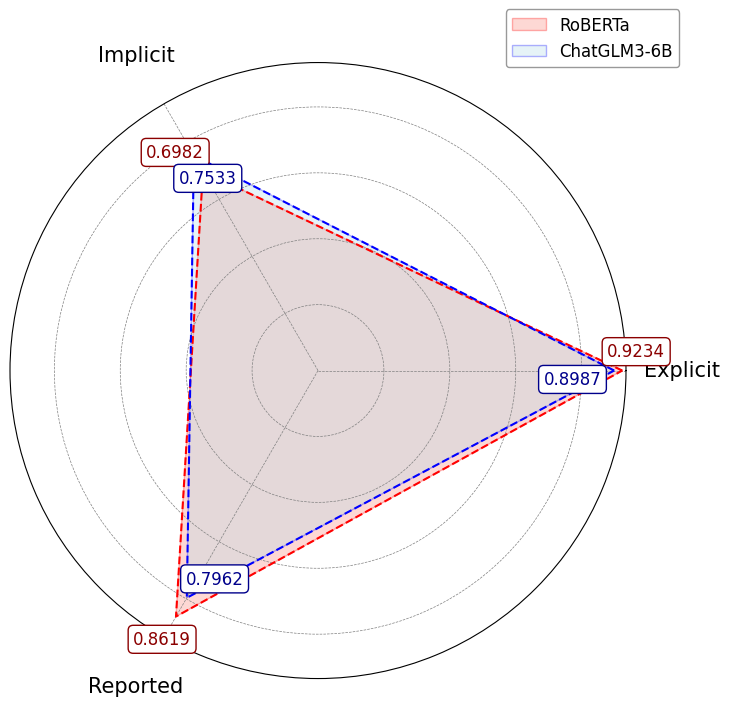

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
labels = np.array(['Explicit', 'Implicit', 'Reported'])
roberta = np.array([0.923372, 0.698157, 0.861878])
llm = np.array([0.8987, 0.7533, 0.7962])

# 计算角度
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# 使雷达图封闭
roberta = np.concatenate((roberta, [roberta[0]]))
llm = np.concatenate((llm, [llm[0]]))
angles += angles[:1]

# 画图
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 雷达填充
ax.fill(angles, roberta, color='salmon', alpha=0.3, edgecolor='red')
ax.fill(angles, llm, color='lightblue', alpha=0.3, edgecolor='blue')

# 添加连线
ax.plot(angles, roberta, color='red', linewidth=1.5, linestyle='dashed')
ax.plot(angles, llm, color='blue', linewidth=1.5, linestyle='dashed')

# 标注数值
for i in range(len(labels)):
    if i == 0:  # Explicit
        ax.annotate(f"{roberta[i]:.4f}", 
                    (angles[i], roberta[i]), 
                    textcoords="offset points", 
                    xytext=(10,10), 
                    ha='center', 
                    fontsize=12, 
                    color='darkred',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkred', facecolor='white'))
        
        ax.annotate(f"{llm[i]:.4f}", 
                    (angles[i], llm[i]), 
                    textcoords="offset points", 
                    xytext=(-30,-10), 
                    ha='center', 
                    fontsize=12, 
                    color='darkblue',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkblue', facecolor='white'))
    
    elif i == 1:  # Implicit
        ax.annotate(f"{roberta[i]:.4f}", 
                    (angles[i], roberta[i]), 
                    textcoords="offset points", 
                    xytext=(-20,10), 
                    ha='center', 
                    fontsize=12, 
                    color='darkred',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkred', facecolor='white'))
        
        ax.annotate(f"{llm[i]:.4f}", 
                    (angles[i], llm[i]), 
                    textcoords="offset points", 
                    xytext=(10,-20), 
                    ha='center', 
                    fontsize=12, 
                    color='darkblue',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkblue', facecolor='white'))

    elif i == 2:  # Reported
        ax.annotate(f"{roberta[i]:.4f}", 
                    (angles[i], roberta[i]), 
                    textcoords="offset points", 
                    xytext=(-10,-20), 
                    ha='center', 
                    fontsize=12, 
                    color='darkred',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkred', facecolor='white'))
        
        ax.annotate(f"{llm[i]:.4f}", 
                    (angles[i], llm[i]), 
                    textcoords="offset points", 
                    xytext=(20,10), 
                    ha='center', 
                    fontsize=12, 
                    color='darkblue',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkblue', facecolor='white'))

# 设置标签
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=15)
ax.xaxis.set_tick_params(pad=30)

# 添加图例
legend = ax.legend(['RoBERTa', 'ChatGLM3-6B'], loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=12)
legend.get_frame().set_edgecolor('grey')

# 调整网格
ax.grid(color='grey', linestyle='--', linewidth=0.5)

plt.show()
